# MCMC posterior and evidence for a few Gaia light curves

This notebook shows how to obtain the posterior of the parameters of the gaussian processes proposed in the paper using [`numpyro`](https://num.pyro.ai/en/stable/index.html), and then how to use this posterior to estimate the Bayesian evidence using [`harmonic`](https://github.com/astro-informatics/harmonic)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from pathlib import Path
import polars as pl
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
import jax.numpy as jnp
import jax.random as random
import numpyro 
import harmonic as hm
import corner

import jax
jax.config.update("jax_enable_x64", True)
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)

from preprocessing import preprocess_lc, pack_light_curve
from mcmc import bayesian_gp_model, run_sampler, predict_gp_parallel, covariance_functions

name_mapping = {
    'mean': r'$\mu$', 
    'red_stdev': r'$\sigma_R$', 
    'red_length':  r'$\ell$',
    'cos_stdev': r'$\sigma_P$',
    'cos_frequency': r'$f$',
    'white_stdev': r'$\sigma_N$', 
}

lc_index = {}
for p in sorted(list(Path('../data/gaia_qso_period_gt100d/').glob('*.parquet'))):
    sids = pl.read_parquet(p, columns=['sourceid']).to_series().to_list()
    for k, s in enumerate(sids):
        lc_index[s] = (p, k)

def get_lc(sid):
    file, rowidx = lc_index[sid]
    df_lc = pl.read_parquet(file, columns=['sourceid', 'g_obstimes', 'g_val', 'g_valerr', 'period']).slice(rowidx, 1)
    period = df_lc.select('period').to_series().item()
    row = pack_light_curve(df_lc, remove_extreme_errors=True)['g']
    time, mag, err = preprocess_lc(row, scale_time=False, center_mag=True, scale_mag=True)
    return time, mag, err, period

Three Gaia sources from our initial QSO selection. We will obtain the posterior of the parameters of the periodic and DRW kernels, and then fit the normalizing flow to the posterior to estimate the evidence

/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:09<00:00, 156.26it/s, 3 steps of size 6.30e-01. acc. prob=0.91]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  cos_frequency      0.00      0.00      0.00      0.00      0.00   1500.15      1.00
      cos_stdev      1.18      0.60      1.03      0.39      2.05   1643.89      1.00
           mean      0.22      0.11      0.22      0.03      0.39   1793.54      1.00
    white_stdev      0.63      0.07      0.63      0.52      0.76   1758.73      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.12it/s]
/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 187.21it/s, 7 steps of size 3.12e-01. acc. prob=0.91]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         mean      0.16      0.63      0.18     -0.85      1.17   1445.34      1.00
   red_length    312.93    224.38    244.64     30.80    677.18    940.20      1.00
    red_stdev      1.55      0.53      1.47      0.76      2.39    942.06      1.00
  white_stdev      0.10      0.05      0.10      0.02      0.18   1287.16      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.40it/s]
/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:07<00:00, 205.46it/s, 3 steps of size 6.88e-01. acc. prob=0.92]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  cos_frequency      0.00      0.00      0.00      0.00      0.00   2098.24      1.00
      cos_stdev      1.30      0.61      1.15      0.47      2.19   1955.44      1.00
           mean      0.26      0.06      0.26      0.16      0.37   1873.61      1.00
    white_stdev      0.37      0.05      0.37      0.29      0.45   1943.73      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.28it/s]
/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|██████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 166.82it/s, 31 steps of size 3.19e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         mean      0.04      0.67      0.06     -1.10      1.06   1759.85      1.00
   red_length    442.77    228.89    403.64    100.53    821.62   1029.88      1.00
    red_stdev      1.53      0.43      1.50      0.83      2.18    954.58      1.00
  white_stdev      0.11      0.06      0.11      0.01      0.19   1253.11      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.32it/s]
/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:06<00:00, 214.63it/s, 3 steps of size 6.28e-01. acc. prob=0.90]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  cos_frequency      0.00      0.00      0.00      0.00      0.00   1842.94      1.00
      cos_stdev      1.30      0.61      1.14      0.50      2.24   1883.88      1.00
           mean     -0.04      0.07     -0.04     -0.16      0.07   1928.50      1.00
    white_stdev      0.28      0.07      0.27      0.17      0.39   1071.97      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.41it/s]
/home/phuijse/Work/gasp/notebooks/../src/mcmc.py:116: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|███████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 168.49it/s, 7 steps of size 3.70e-01. acc. prob=0.92]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
         mean      0.17      0.67      0.15     -0.93      1.26   1733.46      1.00
   red_length    463.31    242.27    417.58     94.41    847.86   1087.66      1.00
    red_stdev      1.49      0.43      1.46      0.79      2.18   1127.72      1.00
  white_stdev      0.20      0.09      0.19      0.02      0.33   1336.54      1.00

Number of divergences: 0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.17it/s]


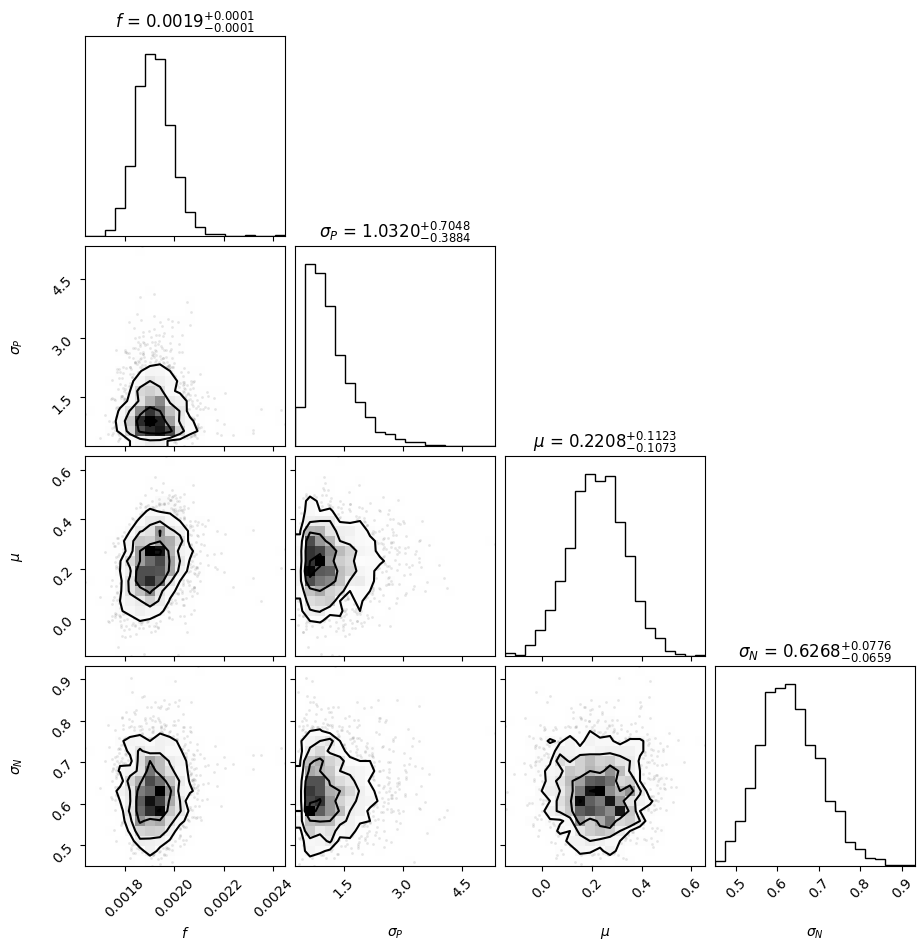

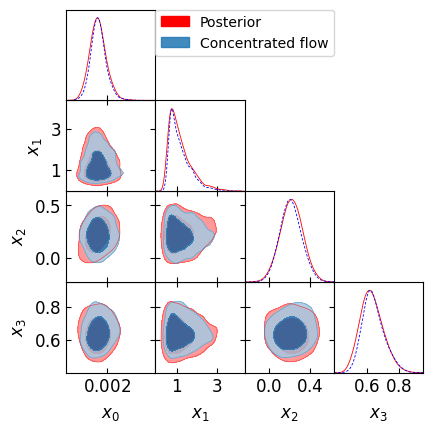

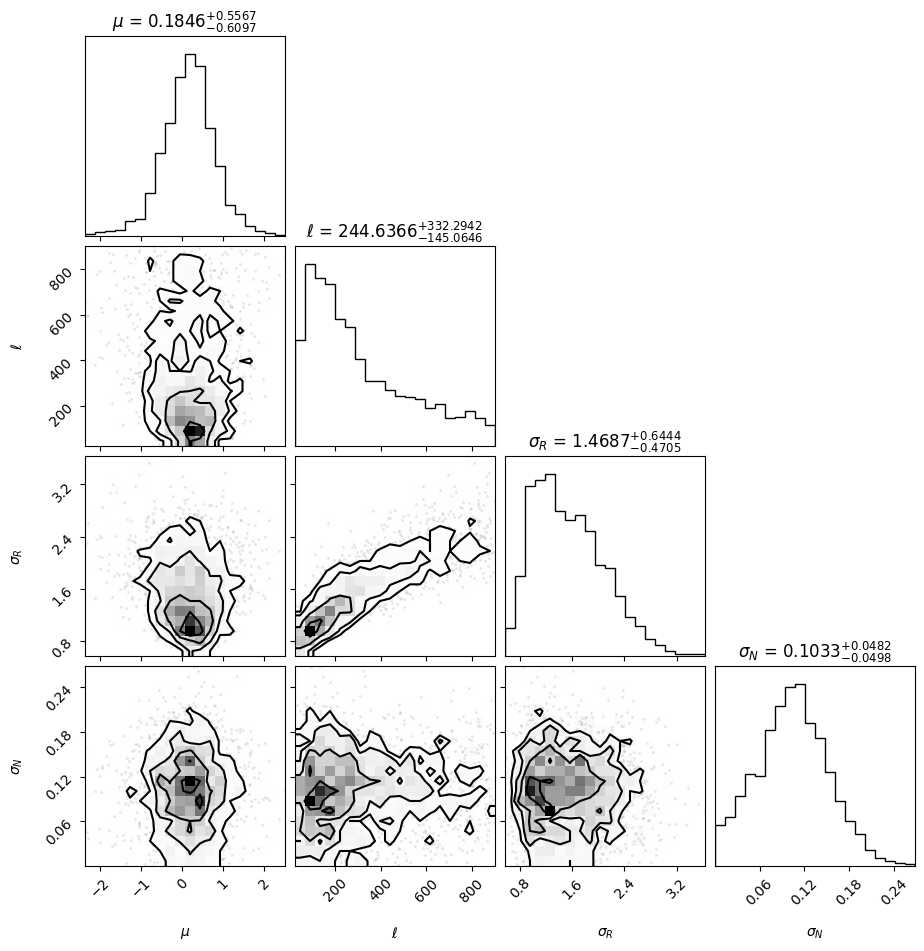

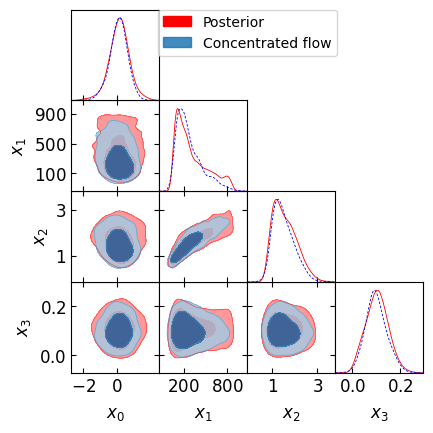

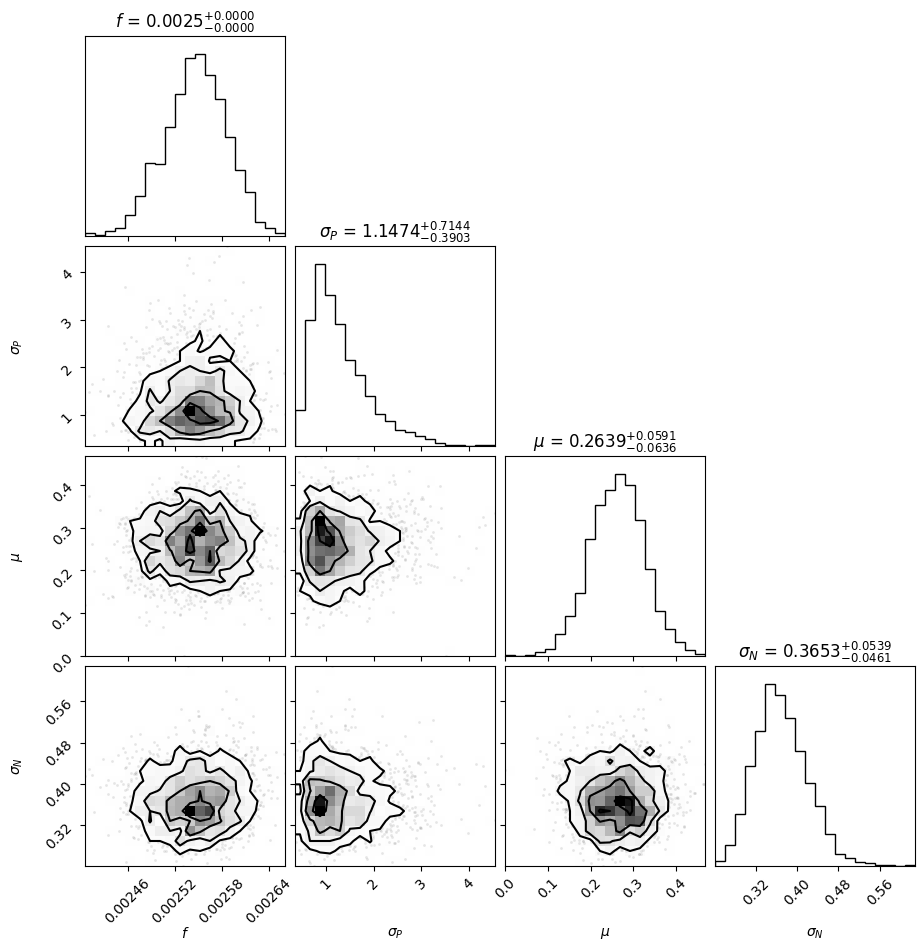

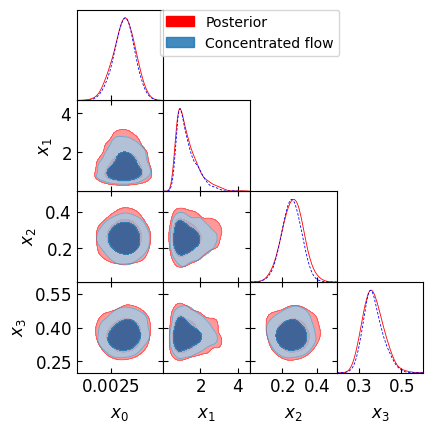

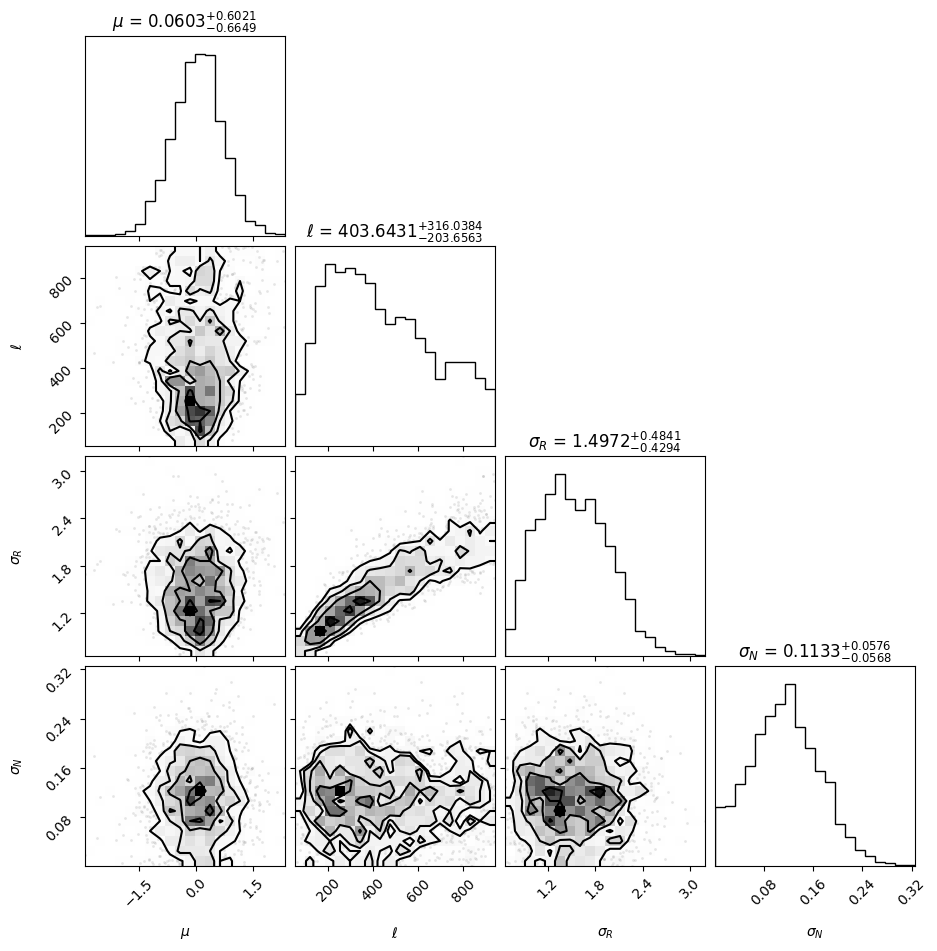

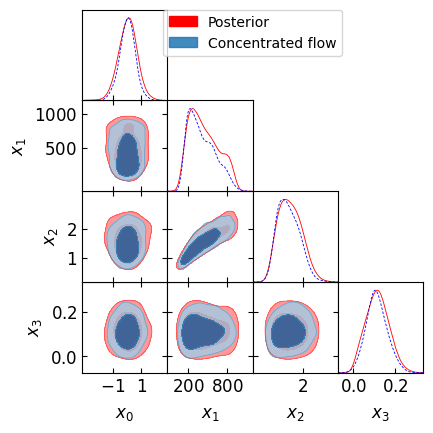

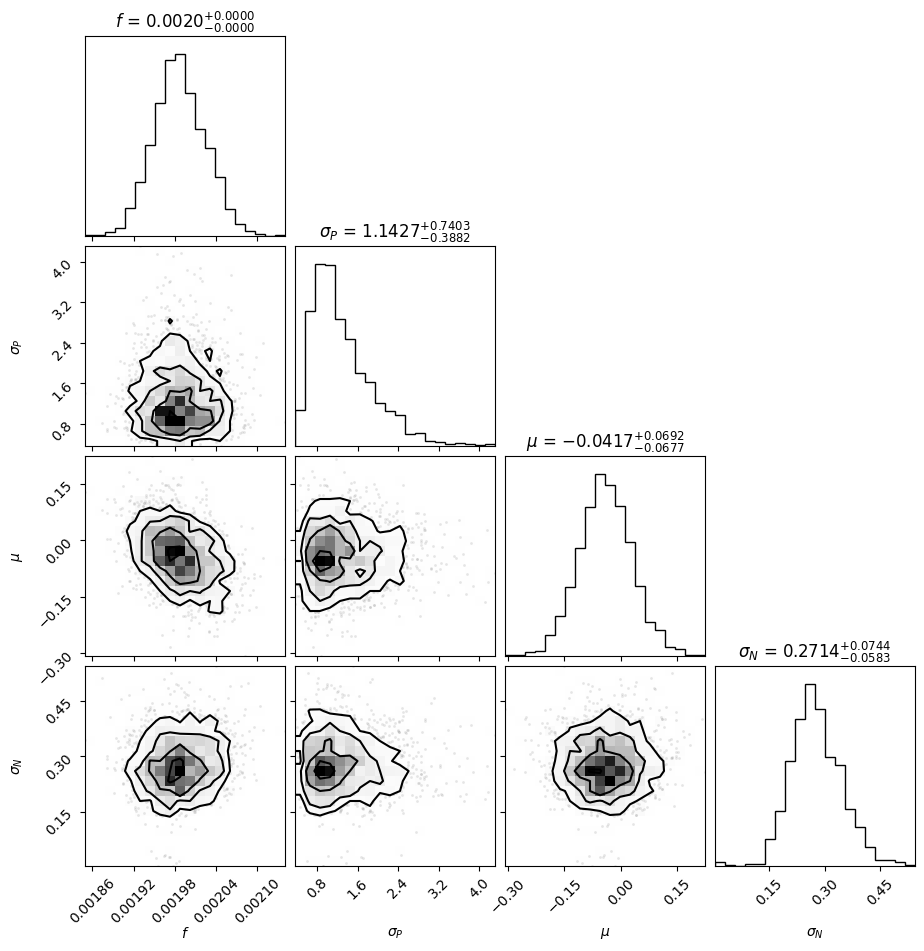

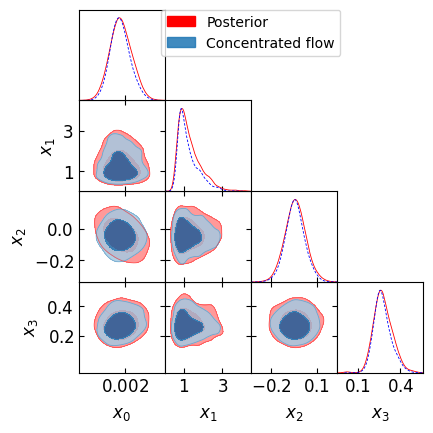

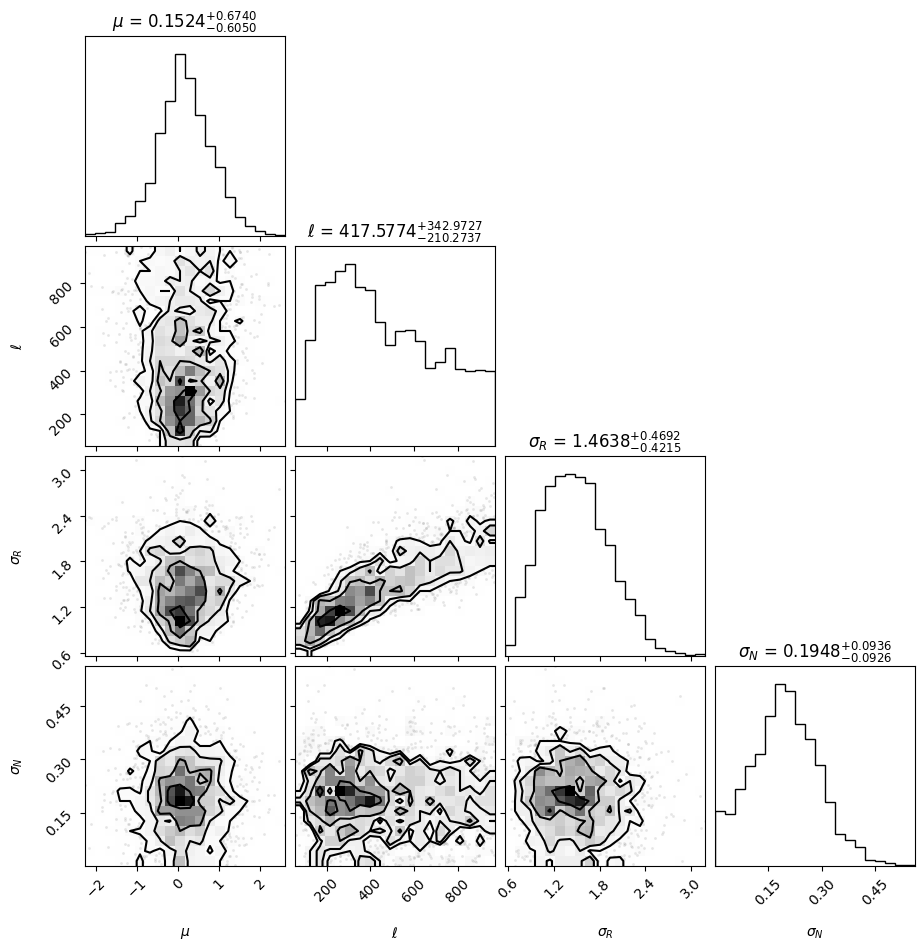

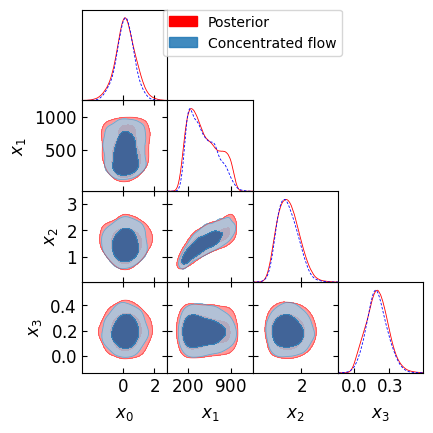

In [2]:
example_sids = [1197868749676521216, 4800138364355730048, 1671482563003627008]
results = {}

temperature = 0.8
epochs_num = 20
num_chains = 4

for sid in example_sids:
    results[sid] = {}
    time, mag, err, period = get_lc(sid)
    for kernel in ['cos', 'red_1']: # The GPs that will be fitted
        # MCMC
        rng_key, rng_key_predict = random.split(random.PRNGKey(0))
        gp_model = partial(bayesian_gp_model, covariance=kernel, period=period)
        samples, log_posterior, _, _ = run_sampler(
            rng_key, jnp.asarray(time), jnp.asarray(mag), jnp.asarray(err),
            gp_model, chain_method='parallel', num_chains=num_chains,
        )
        
        figure = corner.corner(
            np.stack([v for v in samples.values()]).T,
            labels = [name_mapping[k] for k in samples.keys()],
            quantiles=[],
            show_titles=True,
            title_kwargs={"fontsize": 12},
            title_fmt='.4f'
        )
        # Evidence calculation
        samples_c = np.ascontiguousarray(np.stack([v for v in samples.values()]).T)
        ndim = samples_c.shape[1]
        lnprob = np.ascontiguousarray(log_posterior)
        chains = hm.Chains(ndim)
        chains.add_chains_2d(samples_c, lnprob, num_chains) 
        chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)
        nflow_model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature, learning_rate=0.001)
        nflow_model.fit(chains_train.samples, epochs=epochs_num, verbose=True)
        ev = hm.Evidence(chains_infer.nchains, nflow_model)
        ev.add_chains(chains_infer)
        results[sid][kernel] = (samples, ev.compute_ln_evidence()[0]/np.log(10))
        
        flow_samples = nflow_model.sample(samples_c.shape[0])
        hm.utils.plot_getdist_compare(samples_c.reshape((-1, ndim)), flow_samples)

Here we plot the predictive posterior for both kernel for each of the sources. The log Bayes factor, i.e. the difference between the log evidences of the kernels, is shown in the title.

49 0.16792831824960208
46 0.17016575910767756
39 0.2922340647753283


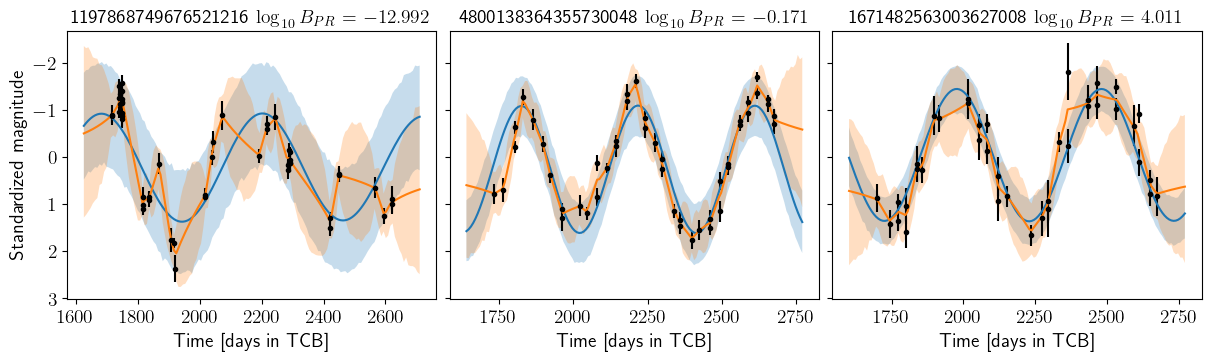

In [3]:
plt.rc('font',   size=16)          
plt.rc('axes',   titlesize=14)     
plt.rc('axes',   labelsize=14)     
plt.rc('xtick',  labelsize=14)     
plt.rc('ytick',  labelsize=14)     
plt.rc('legend', fontsize=16)      
plt.rc('figure', titlesize=16)     
plt.rcParams['text.usetex'] = True # Comment this if you don't have texlive installed

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Standardized magnitude')

for sid, ax in zip(example_sids, axs):
    time, mag, err, period = get_lc(sid)
    print(len(time), np.median(err))
    T = np.amax(time) - np.amin(time)
    time_pred = jnp.linspace(np.amin(time) - T/10, np.amax(time) + T/10, 150)
    ax.errorbar(time, mag, err, fmt='.', c='k')
    ax.invert_yaxis()
    ax.set_xlabel('Time [days in TCB]')
    for kernel in ['cos', 'red_1']:
        post_means, predictions = predict_gp_parallel(
            jnp.asarray(time), jnp.asarray(mag), time_pred, 
            covariance_functions[kernel], results[sid][kernel][0], rng_key_predict
        )
        percentiles = jnp.percentile(predictions, jnp.array([5.0, 95.0]), axis=0)

        ax.plot(time_pred, jnp.mean(post_means, axis=0))
        ax.fill_between(time_pred, percentiles[0], percentiles[-1], alpha=0.25)
    logB = results[sid]['cos'][1] - results[sid]['red_1'][1]
    ax.set_title(f'{sid}' + r' $\log_{10} B_{PR}$ = ' + f'${logB:0.3f}$')
plt.savefig(f'figures/examples_row.pdf', dpi=300, bbox_inches='tight');